### 9.2.1. 门控记忆元
长短期记忆网络引入了记忆元memory cell，简称为单元
有些文献认为记忆元是隐状态的一种特殊类型，他们与隐状态具有相同的形状，
其设计目的为了记录附加的信息。
为了控制记忆元，我们需要许多门。

其中一个门用来从单元中输出条目，称之为输出门output gate
另一个门用来决定何时将数据读入单元，即输入门input gate
还有一种机制用来重置单元的内容，由遗忘门forget gate来管理。

#### 9.2.1.1. 输入门、忘记门和输出门
就如在门控循环单元中一样， 当前时间步的输入和前一个时间步的隐状态 作为数据送入长短期记忆网络的门中， 如 图9.2.1所示。 它们由三个具有sigmoid激活函数的全连接层处理， 以计算输入门、遗忘门和输出门的值。 因此，这三个门的值都在 (0,1) 的范围内。
![lstm](imgs/9_2_1_1输入门忘记门和输出门1.png)
![lstm](imgs/9_2_1_1输入门忘记门和输出门2.png)

#### 9.2.1.2. 候选记忆元

![长短期记忆模型中的候选记忆元](imgs/9_2_1_2候选记忆元1.png)

![长短期记忆模型中的候选记忆元](imgs/9_2_1_2候选记忆元2.png)

#### 9.2.1.3. 记忆元
在门控循环单元中，有一种机制能控制输入和遗忘（或跳过）。
类似的，在LSTM中，也有两个门用于这样的目的：
输入门$I_t$控制采用多少来更新来自$\~C_t$的数据，
而遗忘门$F_t$控制保留多少过去的记忆元$C_{t-1}∈R^{n*h}$的内容
按照元素惩罚，得出
$$C_t = F_t ⊙ C_{t−1} + I_t ⊙ \~C_t$$

如果遗忘门$F_t$始终为1，且输入门$T_t$始终为0，
则过去的记忆元$C_{t-1}$将随时间被保留传递到当前时间步。
引入这种设计是为了缓解梯度消失问题，更好的捕获序列中的长距离依赖关系。

![在长短期记忆网络模型中计算记忆元](imgs/9_2_1_3记忆元1.png)

#### 9.2.1.4. 隐状态
最后，我们需要定义如何计算隐状态$H_t∈R^{n*h}$，这是输出门发挥作用的地方。
在长短期记忆网络中，它仅仅是记忆元的 tanh 的门控版本
 这就确保了 $H_t $的值始终在区间 (−1,1) 内
 $$H_t=O_t ⊙ tanh(C_t)$$

![在长短期记忆模型中计算隐状态](imgs/9_2_1_4隐状态1.png)

### 9.2.2. 从零开始实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

#### 9.2.2.2. 定义模型
在初始化函数中， 长短期记忆网络的隐状态需要返回一个额外的记忆元， 单元的值为0，形状为（批量大小，隐藏单元数）。 因此，我们得到以下的状态初始化。

In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

实际模型的定义与我们前面讨论的一样： 提供三个门和一个额外的记忆元。 请注意，只有隐状态才会传递到输出层， 而记忆元 Ct 不直接参与输出计算。

In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

#### 9.2.2.3. 训练和预测

KeyboardInterrupt: 

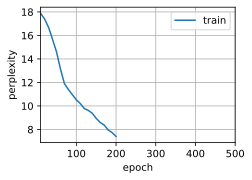

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 9.2.3. 简洁实现

In [ ]:
num_inputs = len(vocab_size)
num_inputs

In [ ]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

长短期记忆网络是典型的具有重要状态控制的隐变量自回归模型。 多年来已经提出了其许多变体，例如，多层、残差连接、不同类型的正则化。 然而，由于序列的长距离依赖性，训练长短期记忆网络 和其他序列模型（例如门控循环单元）的成本是相当高的。 在后面的内容中，我们将讲述更高级的替代模型，如transformer。